In [93]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Définir les transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Charger toutes les images à partir de 'data' avec ImageFolder
young_dataset = datasets.ImageFolder(root='data/young', transform=transform)
old_dataset = datasets.ImageFolder(root='data/old', transform=transform)

# Créer des DataLoaders pour chaque subset
young_loader = DataLoader(young_dataset, batch_size=1, shuffle=True)
old_loader = DataLoader(old_dataset, batch_size=1, shuffle=True)

# Afficher les informations
print(f"Nombre d'images Young : {len(young_dataset)}")
print(f"Nombre d'images Old : {len(old_dataset)}")

Nombre d'images Young : 2345
Nombre d'images Old : 920


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Définition du générateur
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Architecture de type UNet ou ResNet simplifiée ici
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Définition du discriminateur
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [95]:
# Instanciation des générateurs et des discriminateurs
G_XtoY = Generator()
G_YtoX = Generator()
D_X = Discriminator()
D_Y = Discriminator()

# Choisir un taux d'apprentissage
learning_rate = 0.001

# Définir les optimisateurs pour chaque modèle
optimizer_G = torch.optim.Adam(list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [96]:
# Importer torch.nn pour les fonctions de perte
import torch.nn as nn

# Perte adversariale
criterion_gan = nn.MSELoss()  # Perte MSE pour la confrontation générateurs/discriminateurs

# Perte de cycle
criterion_cycle = nn.L1Loss()  # Perte L1 pour maintenir la cohérence cyclique

# Hyperparamètre pour équilibrer la perte de cycle
lambda_cycle = 10.0

In [97]:
from tqdm import tqdm

# Training parameters
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Place models on the GPU if available
G_XtoY = G_XtoY.to(device)
G_YtoX = G_YtoX.to(device)
D_X = D_X.to(device)
D_Y = D_Y.to(device)

# Initialize best loss to a high value
best_loss_G = float('inf')

# Training loop
for epoch in range(num_epochs):
    # Progress bar for batches in the epoch
    epoch_progress = tqdm(zip(young_loader, old_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", total=min(len(young_loader), len(old_loader)))

    for real_X, real_Y in epoch_progress:
        # Load images and place them on the device
        real_X = real_X[0].to(device)
        real_Y = real_Y[0].to(device)

        # -----------------------------------------------------------
        # Step 1: Train Generators G_XtoY and G_YtoX
        # -----------------------------------------------------------

        # Transform Young to Old
        fake_Y = G_XtoY(real_X)
        cycle_X = G_YtoX(fake_Y)

        # Transform Old to Young
        fake_X = G_YtoX(real_Y)
        cycle_Y = G_XtoY(fake_X)

        # Generator loss
        loss_G_XtoY = criterion_gan(D_Y(fake_Y), torch.ones_like(D_Y(fake_Y)).to(device))
        loss_G_YtoX = criterion_gan(D_X(fake_X), torch.ones_like(D_X(fake_X)).to(device))
        loss_cycle_X = criterion_cycle(cycle_X, real_X) * lambda_cycle
        loss_cycle_Y = criterion_cycle(cycle_Y, real_Y) * lambda_cycle

        # Total generator loss
        loss_G = loss_G_XtoY + loss_G_YtoX + loss_cycle_X + loss_cycle_Y

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # -----------------------------------------------------------
        # Step 2: Train Discriminators D_X and D_Y
        # -----------------------------------------------------------

        # Loss for discriminator D_X
        loss_D_X_real = criterion_gan(D_X(real_X), torch.ones_like(D_X(real_X)).to(device))
        loss_D_X_fake = criterion_gan(D_X(fake_X.detach()), torch.zeros_like(D_X(fake_X)).to(device))
        loss_D_X = (loss_D_X_real + loss_D_X_fake) * 0.5

        optimizer_D_X.zero_grad()
        loss_D_X.backward()
        optimizer_D_X.step()

        # Loss for discriminator D_Y
        loss_D_Y_real = criterion_gan(D_Y(real_Y), torch.ones_like(D_Y(real_Y)).to(device))
        loss_D_Y_fake = criterion_gan(D_Y(fake_Y.detach()), torch.zeros_like(D_Y(fake_Y)).to(device))
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) * 0.5

        optimizer_D_Y.zero_grad()
        loss_D_Y.backward()
        optimizer_D_Y.step()

        # Update the progress bar with current losses
        epoch_progress.set_postfix({
            'Loss G': loss_G.item(),
            'Loss D_X': loss_D_X.item(),
            'Loss D_Y': loss_D_Y.item()
        })

    # Check if the current generator loss is the best we've seen
    if loss_G.item() < best_loss_G:
        best_loss_G = loss_G.item()
        print(f"New best model found at Epoch [{epoch+1}/{num_epochs}] with Loss G: {best_loss_G:.4f}")

        # Save the best models for generators and discriminators
        torch.save(G_XtoY.state_dict(), 'G_XtoY.pth')
        torch.save(G_YtoX.state_dict(), 'G_YtoX.pth')
        torch.save(D_X.state_dict(), 'D_X.pth')
        torch.save(D_Y.state_dict(), 'D_Y.pth')

    # Display losses for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss G: {loss_G.item()}, Loss D_X: {loss_D_X.item()}, Loss D_Y: {loss_D_Y.item()}")


Epoch [1/20]: 100%|██████████| 920/920 [00:14<00:00, 64.98it/s, Loss G=2.32, Loss D_X=0.235, Loss D_Y=0.202] 


New best model found at Epoch [1/20] with Loss G: 2.3203
Epoch [1/20], Loss G: 2.320262908935547, Loss D_X: 0.2350151240825653, Loss D_Y: 0.20153450965881348


Epoch [2/20]: 100%|██████████| 920/920 [00:14<00:00, 64.36it/s, Loss G=2.01, Loss D_X=0.264, Loss D_Y=0.3]  


New best model found at Epoch [2/20] with Loss G: 2.0052
Epoch [2/20], Loss G: 2.0052430629730225, Loss D_X: 0.26366785168647766, Loss D_Y: 0.30042609572410583


Epoch [3/20]: 100%|██████████| 920/920 [00:14<00:00, 63.06it/s, Loss G=2.67, Loss D_X=0.256, Loss D_Y=0.325]


Epoch [3/20], Loss G: 2.673046112060547, Loss D_X: 0.2556203007698059, Loss D_Y: 0.3249009847640991


Epoch [4/20]: 100%|██████████| 920/920 [00:14<00:00, 61.68it/s, Loss G=1.99, Loss D_X=0.183, Loss D_Y=0.271] 


New best model found at Epoch [4/20] with Loss G: 1.9941
Epoch [4/20], Loss G: 1.994062900543213, Loss D_X: 0.18251359462738037, Loss D_Y: 0.2707565426826477


Epoch [5/20]: 100%|██████████| 920/920 [00:14<00:00, 61.36it/s, Loss G=1.92, Loss D_X=0.174, Loss D_Y=0.201] 


New best model found at Epoch [5/20] with Loss G: 1.9225
Epoch [5/20], Loss G: 1.9225034713745117, Loss D_X: 0.17389805614948273, Loss D_Y: 0.20106744766235352


Epoch [6/20]: 100%|██████████| 920/920 [00:14<00:00, 63.03it/s, Loss G=1.59, Loss D_X=0.199, Loss D_Y=0.223] 


New best model found at Epoch [6/20] with Loss G: 1.5932
Epoch [6/20], Loss G: 1.593189001083374, Loss D_X: 0.19859689474105835, Loss D_Y: 0.22322359681129456


Epoch [7/20]: 100%|██████████| 920/920 [00:14<00:00, 62.44it/s, Loss G=1.7, Loss D_X=0.143, Loss D_Y=0.226]   


Epoch [7/20], Loss G: 1.7021393775939941, Loss D_X: 0.14250628650188446, Loss D_Y: 0.22573643922805786


Epoch [8/20]: 100%|██████████| 920/920 [00:14<00:00, 62.90it/s, Loss G=1.55, Loss D_X=0.4, Loss D_Y=0.345]    


New best model found at Epoch [8/20] with Loss G: 1.5518
Epoch [8/20], Loss G: 1.551768183708191, Loss D_X: 0.3995121121406555, Loss D_Y: 0.34458446502685547


Epoch [9/20]: 100%|██████████| 920/920 [00:14<00:00, 62.44it/s, Loss G=2.27, Loss D_X=0.408, Loss D_Y=0.271]  


Epoch [9/20], Loss G: 2.266660451889038, Loss D_X: 0.4083347022533417, Loss D_Y: 0.2710072696208954


Epoch [10/20]: 100%|██████████| 920/920 [00:15<00:00, 61.15it/s, Loss G=1.43, Loss D_X=0.405, Loss D_Y=0.353]  


New best model found at Epoch [10/20] with Loss G: 1.4336
Epoch [10/20], Loss G: 1.4335657358169556, Loss D_X: 0.4053299129009247, Loss D_Y: 0.3532361090183258


Epoch [11/20]: 100%|██████████| 920/920 [00:14<00:00, 63.30it/s, Loss G=1.82, Loss D_X=0.189, Loss D_Y=0.203]  


Epoch [11/20], Loss G: 1.8193947076797485, Loss D_X: 0.1889524608850479, Loss D_Y: 0.20266294479370117


Epoch [12/20]: 100%|██████████| 920/920 [00:14<00:00, 62.18it/s, Loss G=1.65, Loss D_X=0.127, Loss D_Y=0.152]  


Epoch [12/20], Loss G: 1.6492860317230225, Loss D_X: 0.12695932388305664, Loss D_Y: 0.15157970786094666


Epoch [13/20]: 100%|██████████| 920/920 [00:14<00:00, 62.07it/s, Loss G=1.52, Loss D_X=0.188, Loss D_Y=0.212]  


Epoch [13/20], Loss G: 1.522594928741455, Loss D_X: 0.1875368356704712, Loss D_Y: 0.21225190162658691


Epoch [14/20]: 100%|██████████| 920/920 [00:14<00:00, 62.78it/s, Loss G=1.54, Loss D_X=0.278, Loss D_Y=0.227]  


Epoch [14/20], Loss G: 1.5402278900146484, Loss D_X: 0.27779141068458557, Loss D_Y: 0.22692179679870605


Epoch [15/20]: 100%|██████████| 920/920 [00:15<00:00, 58.58it/s, Loss G=1.42, Loss D_X=0.16, Loss D_Y=0.144]   


New best model found at Epoch [15/20] with Loss G: 1.4180
Epoch [15/20], Loss G: 1.418046474456787, Loss D_X: 0.160067617893219, Loss D_Y: 0.14407384395599365


Epoch [16/20]: 100%|██████████| 920/920 [00:14<00:00, 61.51it/s, Loss G=1.57, Loss D_X=0.146, Loss D_Y=0.15]   


Epoch [16/20], Loss G: 1.5717346668243408, Loss D_X: 0.14601004123687744, Loss D_Y: 0.15040402114391327


Epoch [17/20]: 100%|██████████| 920/920 [00:14<00:00, 62.88it/s, Loss G=1.71, Loss D_X=0.219, Loss D_Y=0.293]  


Epoch [17/20], Loss G: 1.713243007659912, Loss D_X: 0.21880632638931274, Loss D_Y: 0.2930219769477844


Epoch [18/20]: 100%|██████████| 920/920 [00:14<00:00, 62.83it/s, Loss G=2.04, Loss D_X=0.175, Loss D_Y=0.167]  


Epoch [18/20], Loss G: 2.0448529720306396, Loss D_X: 0.17509612441062927, Loss D_Y: 0.16729769110679626


Epoch [19/20]: 100%|██████████| 920/920 [00:15<00:00, 61.28it/s, Loss G=1.41, Loss D_X=0.324, Loss D_Y=0.252]  


New best model found at Epoch [19/20] with Loss G: 1.4102
Epoch [19/20], Loss G: 1.4101612567901611, Loss D_X: 0.3243391513824463, Loss D_Y: 0.2520408630371094


Epoch [20/20]: 100%|██████████| 920/920 [00:14<00:00, 61.89it/s, Loss G=1.98, Loss D_X=0.135, Loss D_Y=0.179]  

Epoch [20/20], Loss G: 1.9771595001220703, Loss D_X: 0.13461054861545563, Loss D_Y: 0.1785811483860016


In [98]:
# Save the models

torch.save(G_XtoY.state_dict(), 'G_XtoY.pth')
torch.save(G_YtoX.state_dict(), 'G_YtoX.pth')
torch.save(D_X.state_dict(), 'D_X.pth')
torch.save(D_Y.state_dict(), 'D_Y.pth')

In [4]:
import torch

# Load the models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

G_XtoY = Generator()
G_YtoX = Generator()

G_XtoY.load_state_dict(torch.load('G_XtoY.pth', map_location=device))
G_YtoX.load_state_dict(torch.load('G_YtoX.pth', map_location=device))

/tmp/ipykernel_12131/1407098631.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_XtoY.load_state_dict(torch.load('G_XtoY.pth', map_location=device))
/tmp/ipykernel_1213

<All keys matched successfully>

In [6]:
# Print number of parameters for each model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'G_XtoY has {count_parameters(G_XtoY):,} trainable parameters')

discriminator = Discriminator()
print(f'Discriminator has {count_parameters(discriminator):,} trainable parameters')

G_XtoY has 1,317,507 trainable parameters
Discriminator has 663,745 trainable parameters


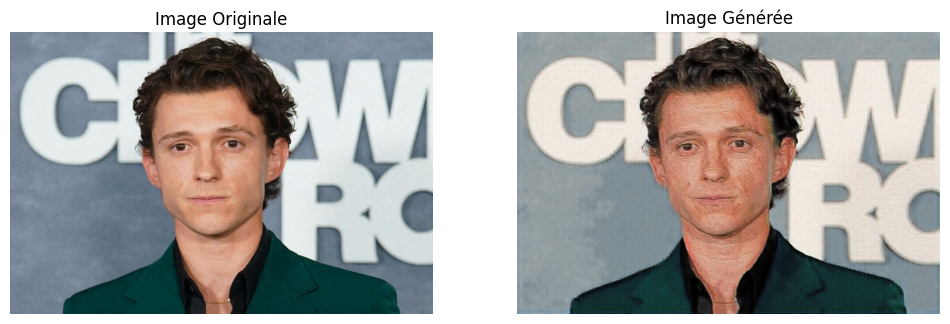

In [104]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Fonction pour transformer une image jeune en image âgée
def transform_to_old(image_path, generator, device):
    # Charger l'image
    image = Image.open(image_path).convert('RGB')

    # Appliquer les transformations (redimensionner, normaliser, convertir en tensor)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalisation comme durant l'entraînement
    ])

    image = transform(image).unsqueeze(0).to(device)  # Ajouter une dimension pour batch size (1)

    # Passer l'image à travers le générateur pour obtenir l'image âgée
    with torch.no_grad():  # Pas de besoin de gradients pour la génération
        generated_image = generator(image)

    # Inverser la normalisation de l'image originale pour restaurer les couleurs
    image = image.squeeze(0).cpu()  # Enlever la dimension du batch
    image = image * 0.5 + 0.5  # Revenir à la plage [0, 1]

    # Convertir l'image générée de tensor à image pour affichage
    generated_image = generated_image.squeeze(0).cpu().clamp_(-1, 1)  # Squeeze pour enlever la dimension du batch
    generated_image = generated_image * 0.5 + 0.5  # Inverser la normalisation aussi
    generated_image = transforms.ToPILImage()(generated_image)  # Convertir en PIL Image

    # Convertir l'image originale en format PIL pour l'affichage
    real_image = transforms.ToPILImage()(image)

    return real_image, generated_image


# Exemple d'utilisation
image_path = '/home/thomas/Downloads/tom-holland.jpg'  # Remplacer par le chemin de votre image d'entrée
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Charger le modèle générateur préalablement entraîné
generator = G_XtoY.to(device)  # Assurez-vous que le modèle est sur le bon device

# Transformer l'image humaine en style Simpsons
real_image, simpsons_image = transform_to_old(image_path, generator, device)

# Afficher les deux images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Afficher l'image originale (humain)
axes[0].imshow(real_image)
axes[0].set_title('Image Originale')
axes[0].axis('off')

# Afficher l'image générée (Simpsons)
axes[1].imshow(simpsons_image)
axes[1].set_title('Image Générée')
axes[1].axis('off')

# Afficher le résultat
plt.show()


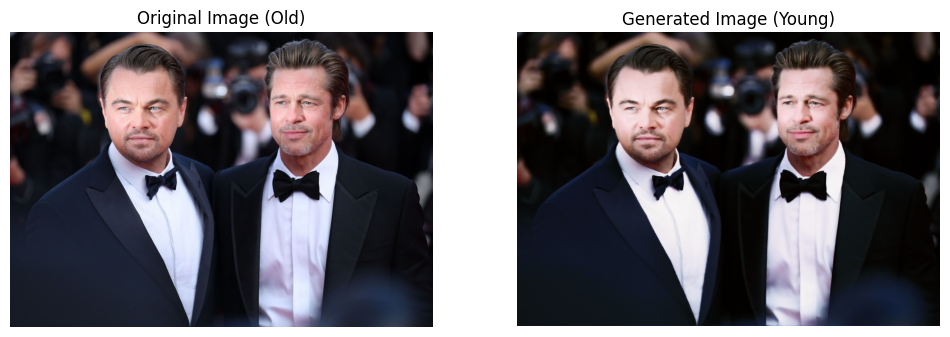

In [101]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Function to transform an "old" image to a "young" style
def transform_to_young(image_path, generator, device):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations (resize, normalize, convert to tensor)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalization as during training
    ])

    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Pass the image through the generator to get the "young" style image
    with torch.no_grad():  # No gradients needed for generation
        generated_image = generator(image)

    # Reverse normalization for the original image to restore colors
    image = image.squeeze(0).cpu()  # Remove batch dimension
    image = image * 0.5 + 0.5  # Convert back to [0, 1] range

    # Convert the generated image tensor to displayable format
    generated_image = generated_image.squeeze(0).cpu().clamp_(-1, 1)  # Remove batch dimension
    generated_image = generated_image * 0.5 + 0.5  # Reverse normalization
    generated_image = transforms.ToPILImage()(generated_image)  # Convert to PIL Image

    # Convert the original image to PIL format for display
    real_image = transforms.ToPILImage()(image)

    return real_image, generated_image


# Example usage
image_path = '/home/thomas/Downloads/2bg.jpg'  # Replace with the path to your "old" input image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pre-trained generator model for transforming old-to-young
generator = G_YtoX.to(device)  # Ensure the model is on the correct device

# Transform the "old" image to "young" style
real_image, young_image = transform_to_young(image_path, generator, device)

# Display the two images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show the original image (old)
axes[0].imshow(real_image)
axes[0].set_title('Original Image (Old)')
axes[0].axis('off')

# Show the generated image (young)
axes[1].imshow(young_image)
axes[1].set_title('Generated Image (Young)')
axes[1].axis('off')

# Show the result
plt.show()